# Importations and data reading

In [33]:
# Data manipulation and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
# Set seaborn style and context
sns.set()
sns.set_context('notebook', font_scale=1.2)

# Pandas display options
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

# Scikit-learn libraries for model building and evaluation
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report

# Imbalanced-learn library for handling imbalanced datasets
from imblearn.over_sampling import RandomOverSampler
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")




In [34]:
data=pd.read_csv(r'file:///C:\Users\OUMA%20BECKS\Desktop\Stroke\stroke-data.csv')
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Preprocessing

First thing I notice is the id column and NaN value in the BMI column. I don't think ID will be useful in our analysis, so I will just drop it.

In [35]:
data.drop('id', axis=1, inplace=True)

In [36]:
data.shape

(5110, 11)

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


We can see that Hypertension, heart disease and stroke have an integer data type but we know that they are categorical variables. So I will convert them to object datatype.

In [38]:
data[['hypertension', 'heart_disease', 'stroke']] = data[['hypertension', 'heart_disease', 'stroke']].astype(str)

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   object 
 3   heart_disease      5110 non-null   object 
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   object 
dtypes: float64(3), object(8)
memory usage: 439.3+ KB


In [40]:
data.describe()

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,4909.000000
mean,43.226614,106.147677,28.893237
std,22.612647,45.283560,7.854067
min,0.080000,55.120000,10.300000
25%,25.000000,77.245000,23.500000
50%,45.000000,91.885000,28.100000
75%,61.000000,114.090000,33.100000
max,82.000000,271.740000,97.600000


It seems like we have some outliers in avg_glucose_level and bmi column. So lets construct a boxplot of our numerical variable to check for outliers

# Exploratory Data Analysis

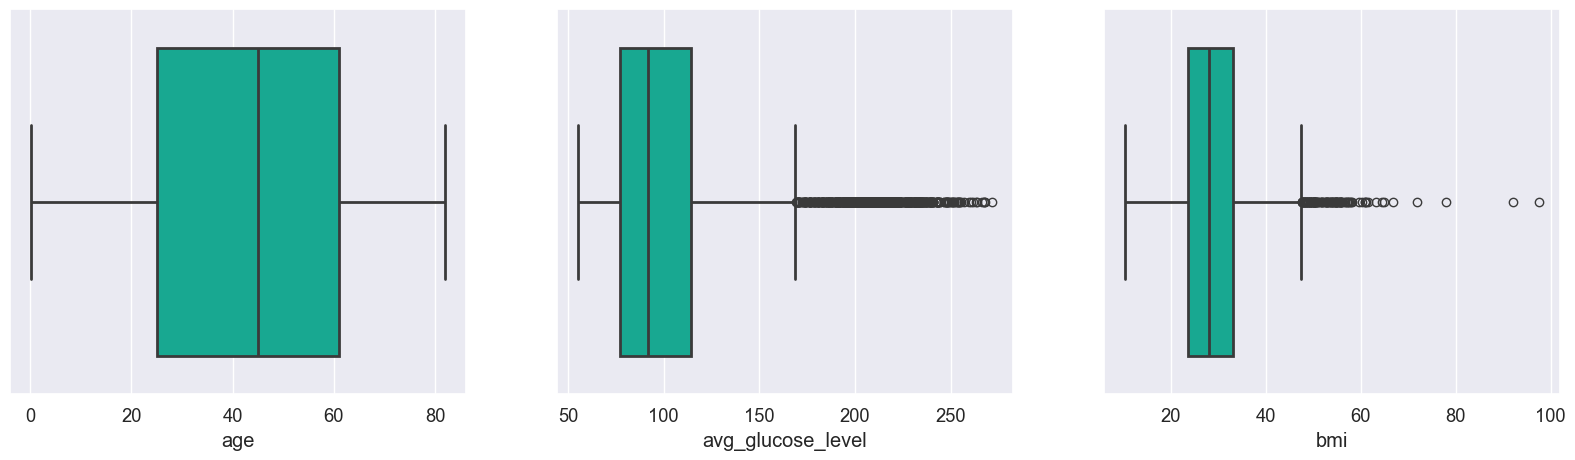

In [41]:
fig, ax = plt.subplots(1, 3, figsize = (20, 5))
sns.boxplot(x = data['age'], ax= ax[0], color= '#00C0A1', linewidth= 2)
sns.boxplot(x = data['avg_glucose_level'], ax= ax[1], color= '#00C0A1', linewidth= 2)
sns.boxplot(x = data['bmi'], ax= ax[2], color= '#00C0A1', linewidth= 2)
plt.show()

We clearly have a lot of outliers in avg_glucose_level and BMI column. Let us also check how their distribution changes according to our target variable before we deal with these outliers

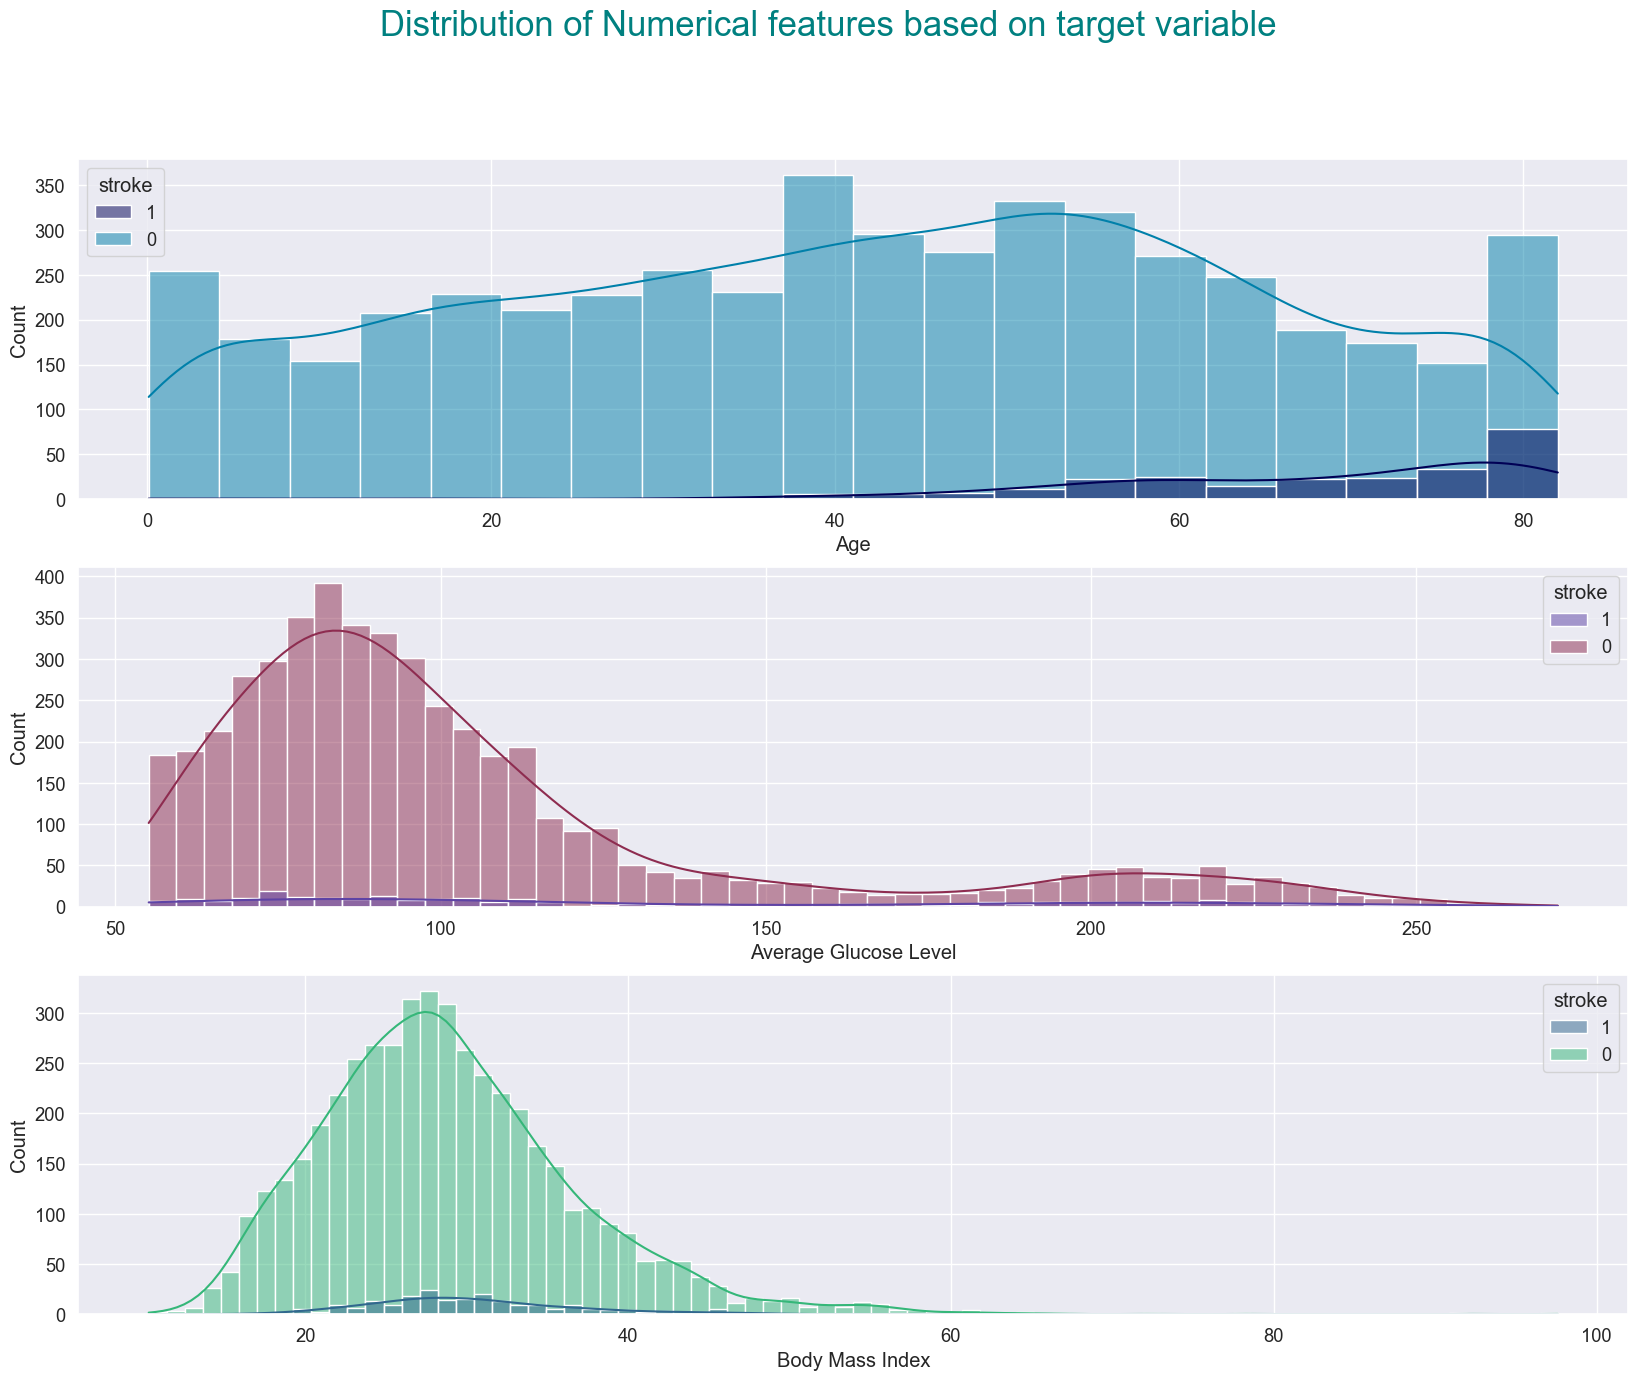

In [42]:
fig, ax = plt.subplots(3, 1, figsize = (20, 15))
plt.suptitle('Distribution of Numerical features based on target variable', fontsize = 25, color = 'teal')
sns.histplot(x = data['age'], hue= data['stroke'], kde= True, ax= ax[0], palette = 'ocean')
ax[0].set(xlabel = 'Age')
sns.histplot(x = data['avg_glucose_level'], hue= data['stroke'], kde= True, ax= ax[1], palette = 'twilight')
ax[1].set(xlabel = 'Average Glucose Level')
sns.histplot(x = data['bmi'], hue= data['stroke'], kde= True, ax= ax[2], palette = 'viridis')
ax[2].set(xlabel = 'Body Mass Index')
plt.show()

We clearly spot a pattern in the distribution of Age. Older people have a much higher chance of getting a stroke as compared to younger individuals.

Let us deal with outliers in the avg_glucose_level and bmi column. I will apply log transformation to these columns

In [43]:
for col in ['avg_glucose_level', 'bmi']:
    data[col] = np.log(data[col])

In [44]:
data.describe()

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,4909.000000
mean,43.226614,4.592465,3.328423
std,22.612647,0.361985,0.265064
min,0.080000,4.009513,2.332144
25%,25.000000,4.346982,3.157000
50%,45.000000,4.520538,3.335770
75%,61.000000,4.736988,3.499533
max,82.000000,5.604846,4.580877


Now lets try to visualise the unique values we have in our categorical features.

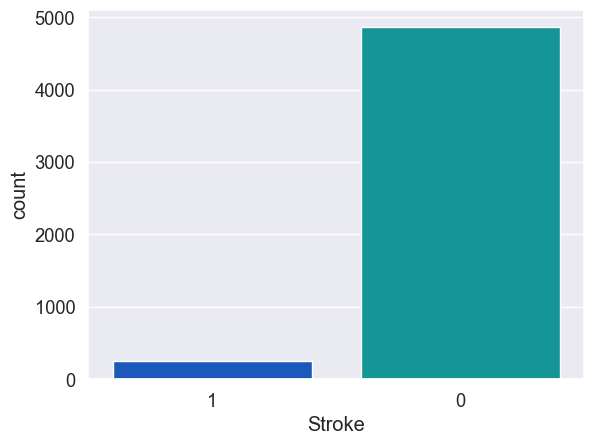

In [45]:
sns.countplot(x = data['stroke'], palette= 'winter')
plt.xlabel('Stroke');


The number of people who actually had a stroke are very less in our dataset. We will have to keep that in mind when we split our dataset

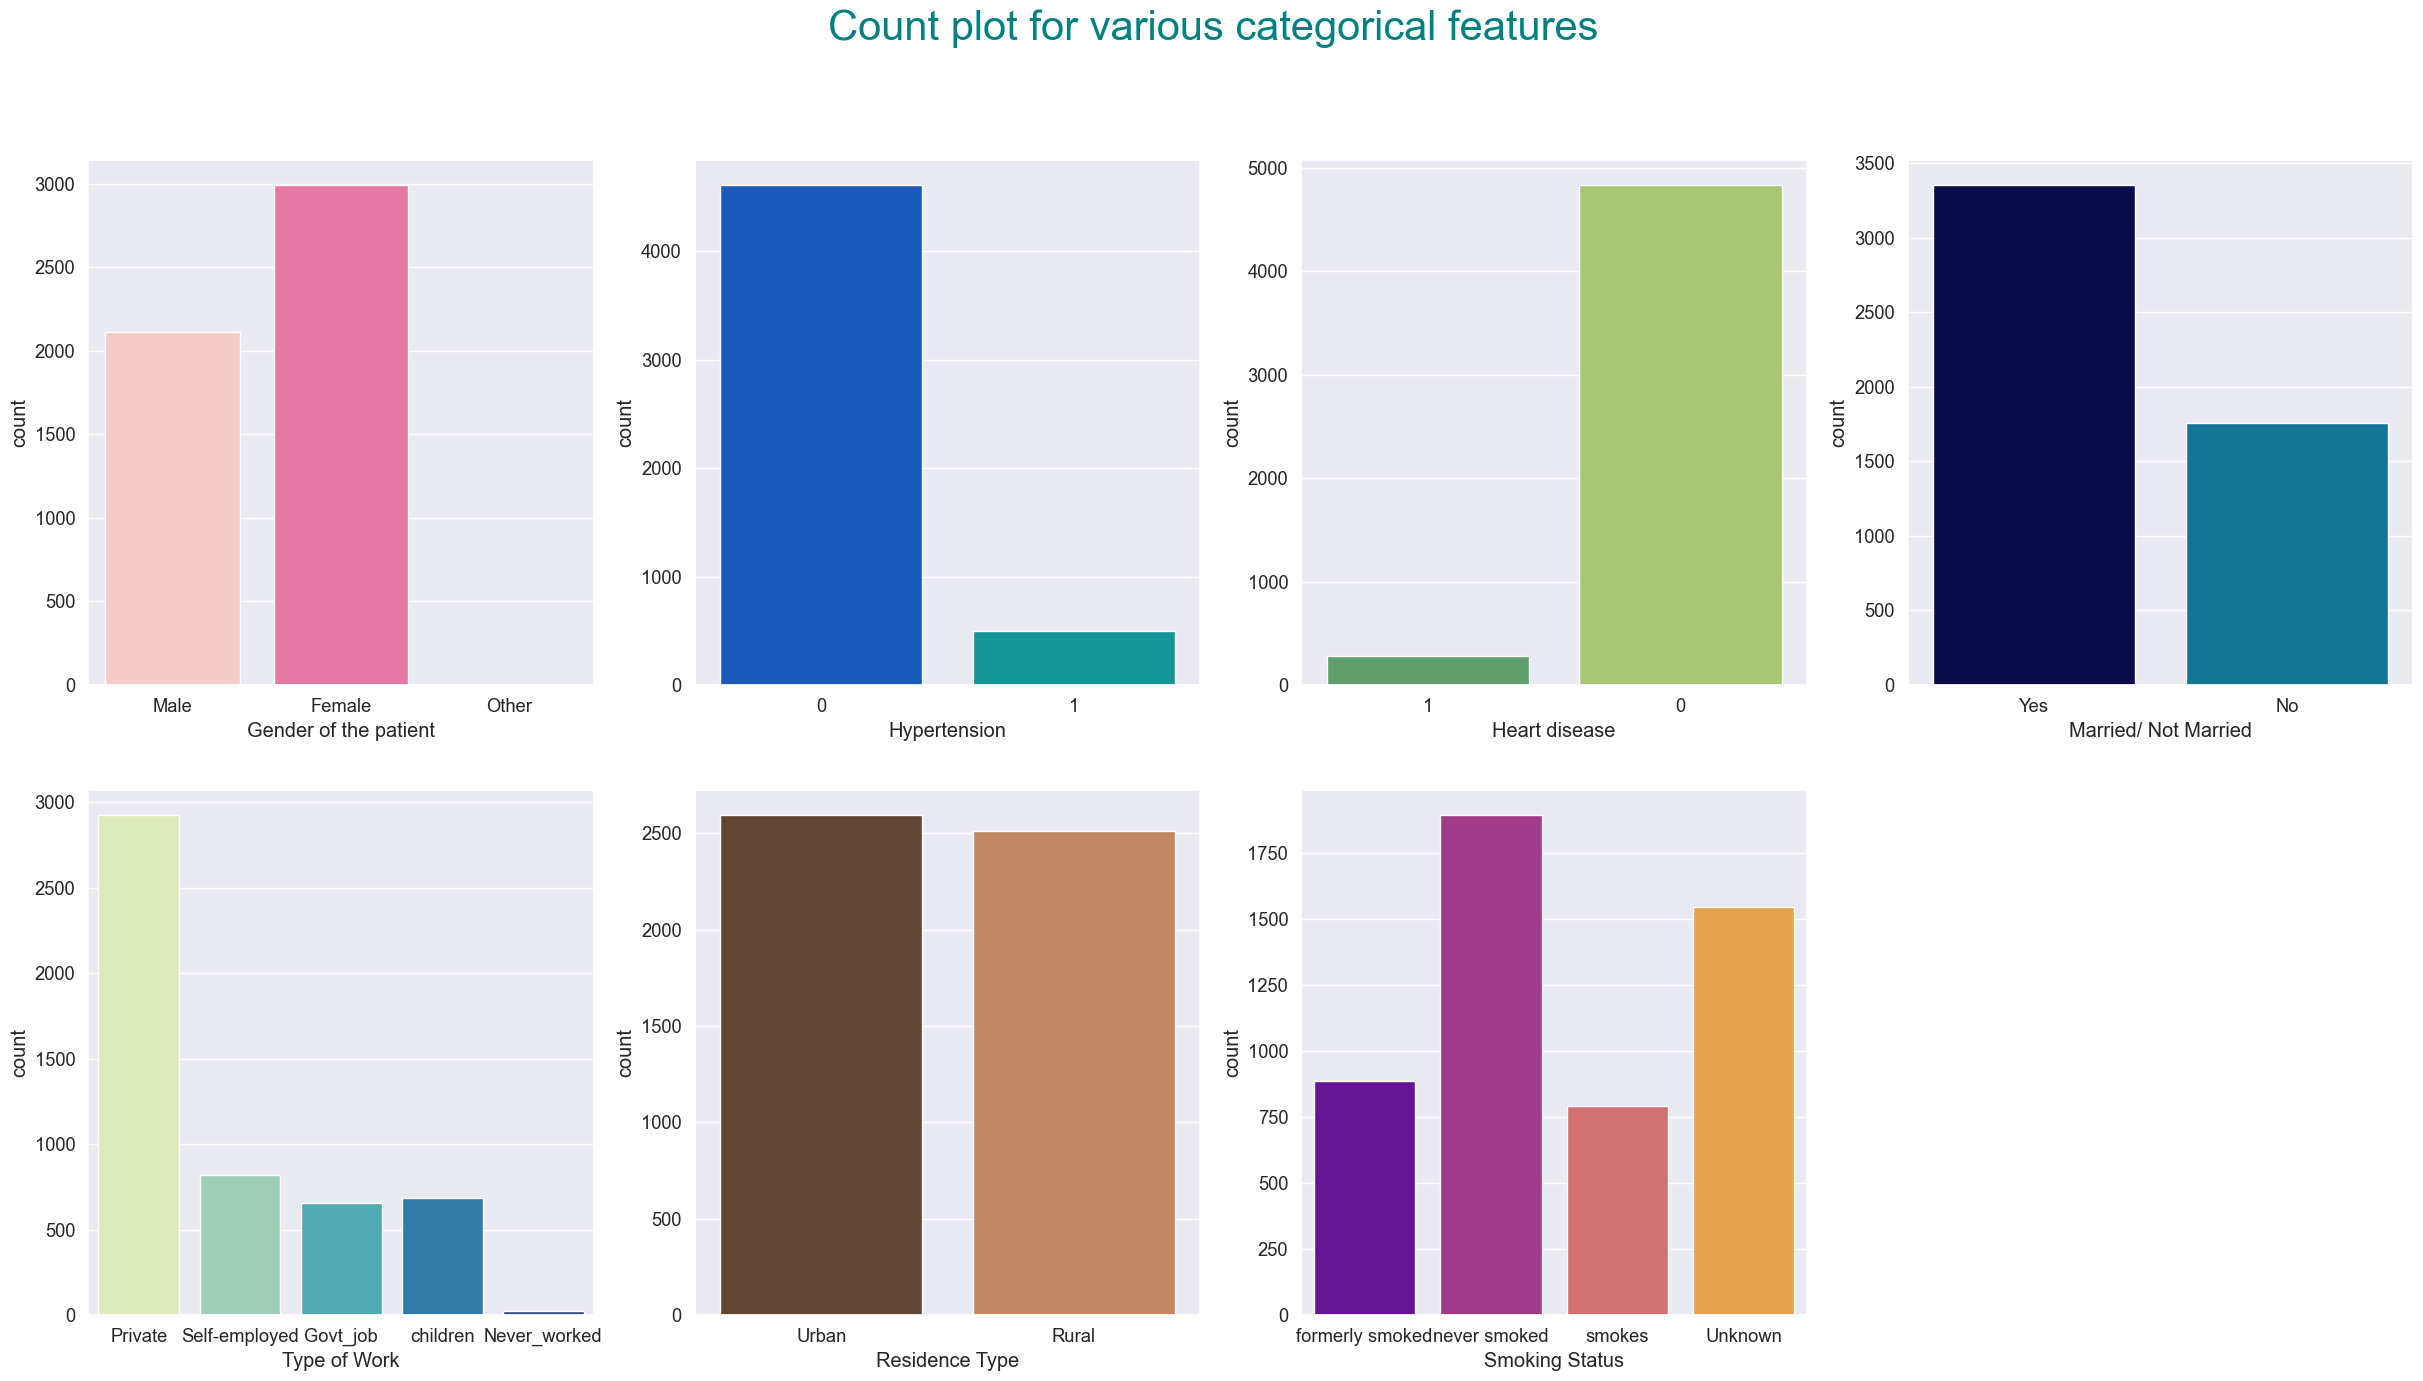

In [46]:
fig, ax = plt.subplots(2, 4, figsize = (30, 15))
ax[1, 3].axis('off')

plt.suptitle('Count plot for various categorical features', fontsize = 30, color= 'teal')

ax1 = sns.countplot(x ='gender', data= data, ax= ax[0, 0], palette= 'RdPu')
ax1.set(xlabel = 'Gender of the patient')

ax2 = sns.countplot(x ='hypertension', data= data, ax= ax[0, 1], palette= 'winter')
ax2.set(xlabel = 'Hypertension')

ax3 = sns.countplot(x ='heart_disease', data= data, ax= ax[0, 2], palette= 'summer')
ax3.set(xlabel = 'Heart disease')

ax4 = sns.countplot(x ='ever_married', data= data, ax= ax[0, 3], palette= 'ocean')
ax4.set(xlabel = 'Married/ Not Married')

ax5 = sns.countplot(x ='work_type', data= data, ax= ax[1, 0], palette= 'YlGnBu')
ax5.set(xlabel = 'Type of Work')

ax6 = sns.countplot(x ='Residence_type', data= data, ax= ax[1, 1], palette= 'copper')
ax6.set(xlabel = 'Residence Type')

ax7 = sns.countplot(x ='smoking_status', data= data, ax= ax[1, 2], palette= 'plasma')
ax7.set(xlabel = 'Smoking Status')

plt.show()

One thing I did notice is we have a Other category in Gender column. I am just going to drop it for simplicity sake.

In [47]:
data['gender'].value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

In [48]:
data.drop(data[data['gender']=='Other'].index, inplace= True)

Now let us try and visualise our categorical features based on our target variable

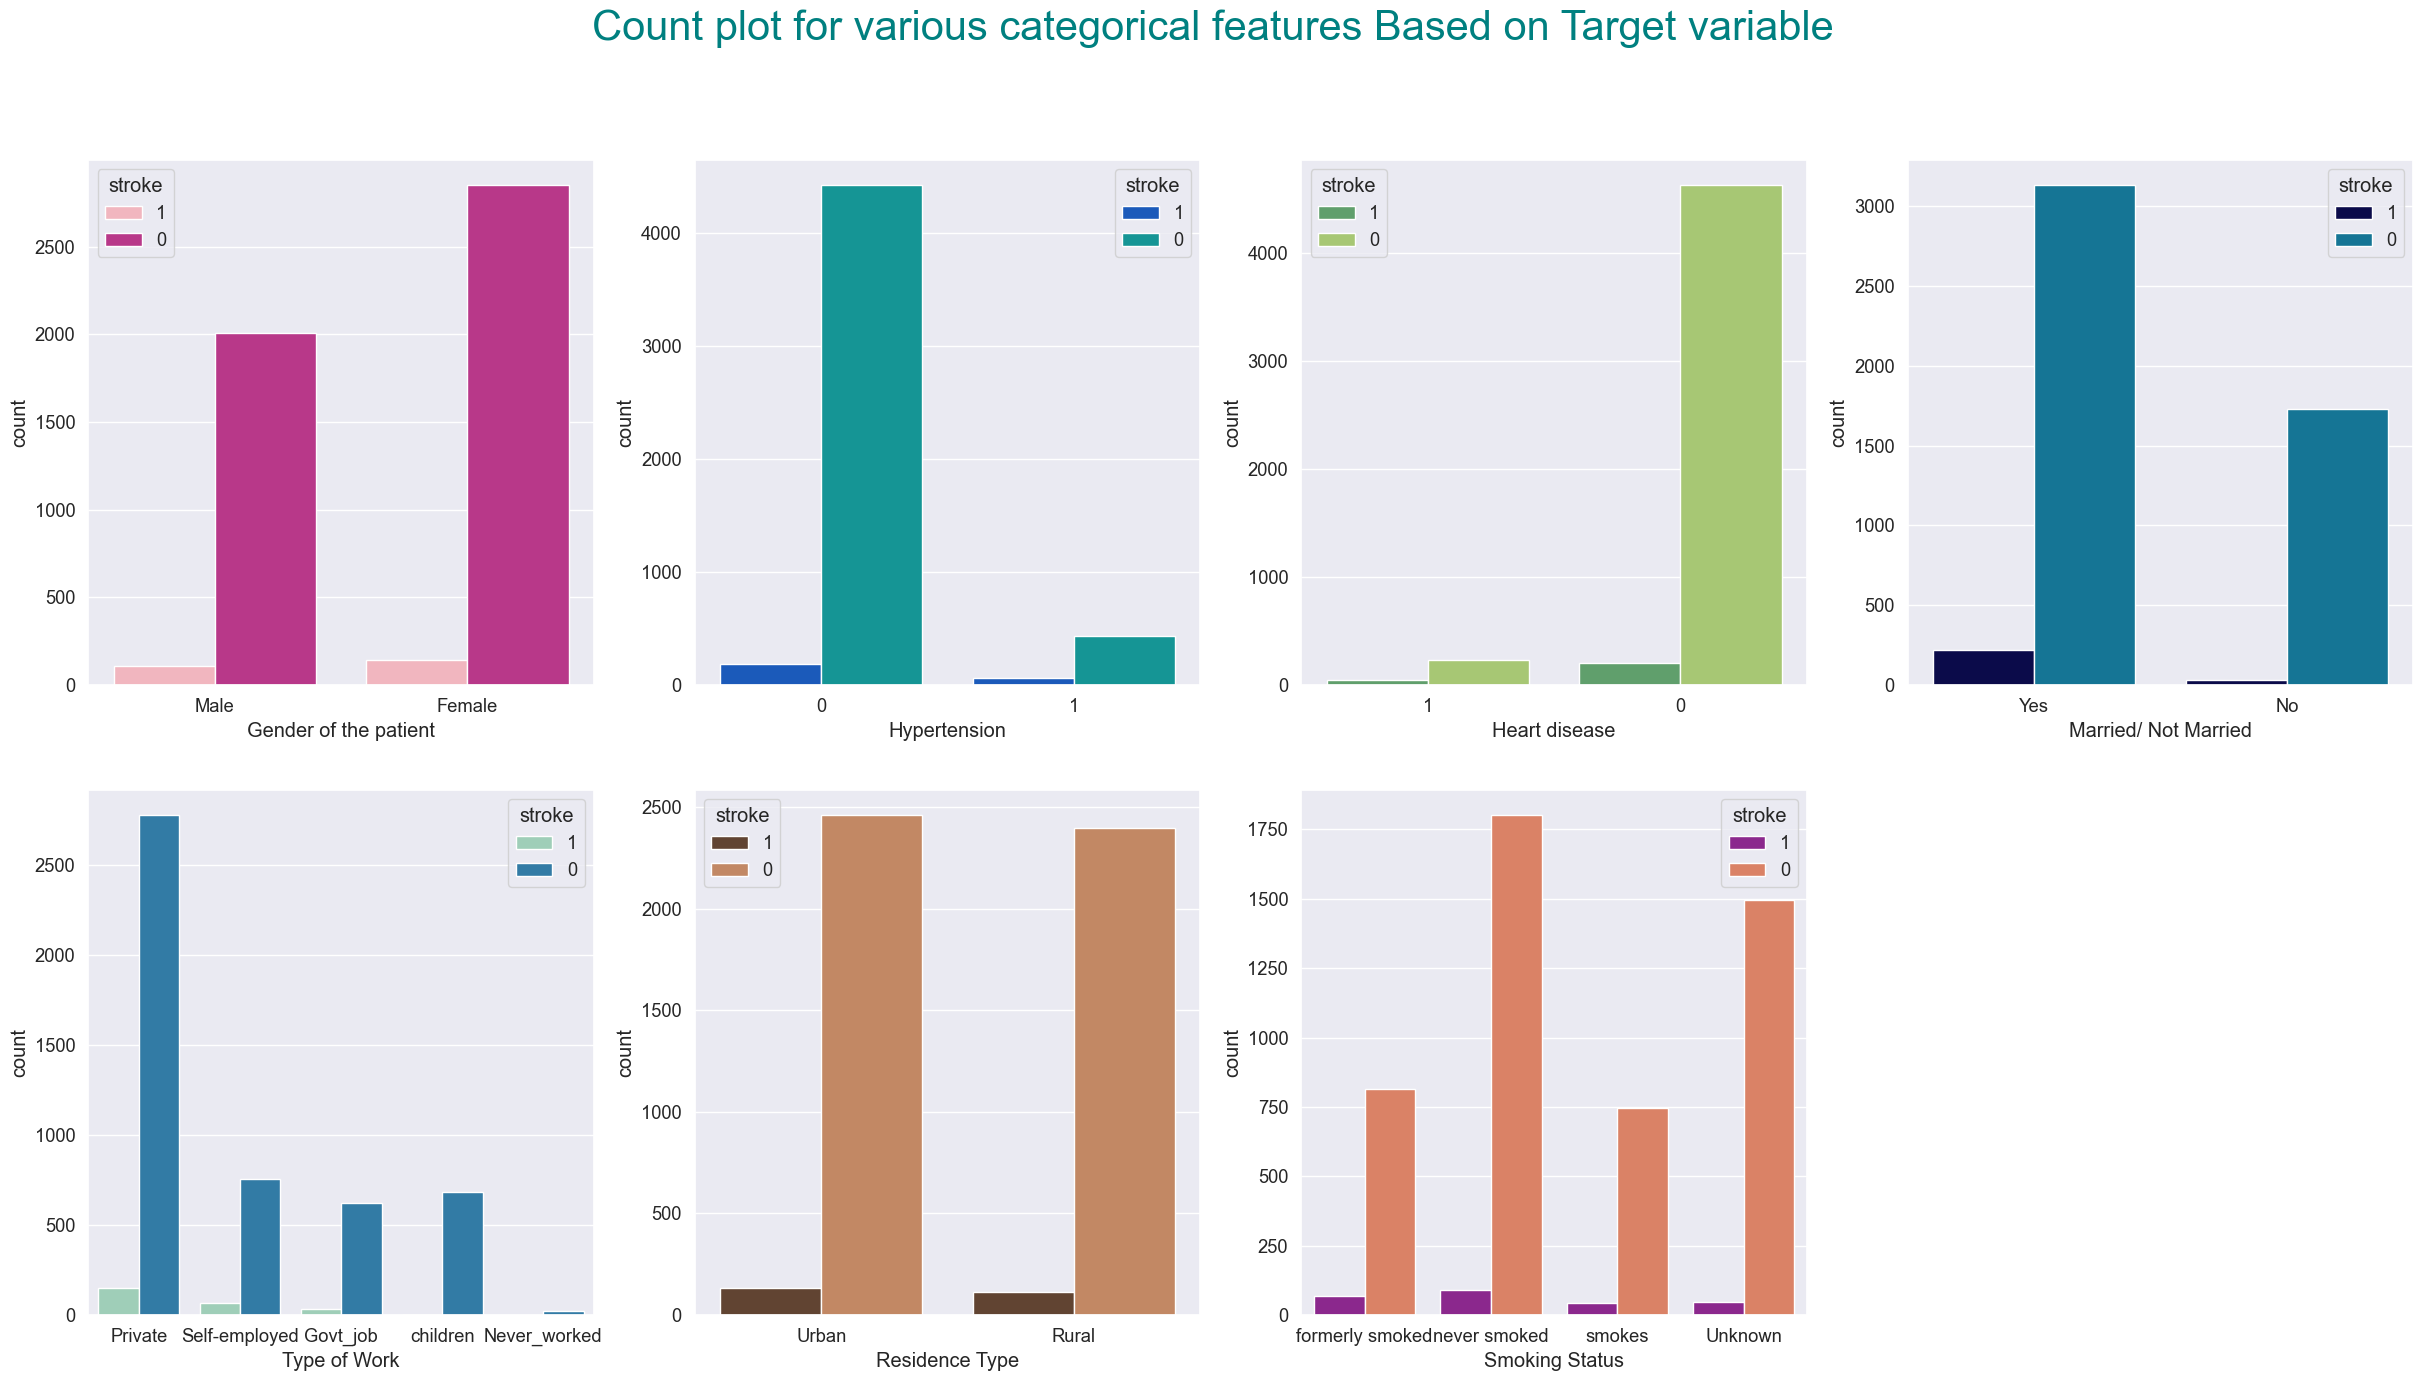

In [49]:

fig, ax = plt.subplots(2, 4, figsize = (30, 15))
ax[1, 3].axis('off')

plt.suptitle('Count plot for various categorical features Based on Target variable', fontsize = 30, color = 'teal')

ax1 = sns.countplot(x ='gender', data= data, hue= 'stroke', ax= ax[0, 0], palette= 'RdPu')
ax1.set(xlabel = 'Gender of the patient')

ax2 = sns.countplot(x ='hypertension', data= data, hue= 'stroke', ax= ax[0, 1], palette= 'winter')
ax2.set(xlabel = 'Hypertension')

ax3 = sns.countplot(x ='heart_disease', data= data, hue= 'stroke', ax= ax[0, 2], palette= 'summer')
ax3.set(xlabel = 'Heart disease')

ax4 = sns.countplot(x ='ever_married', data= data, hue= 'stroke', ax= ax[0, 3], palette= 'ocean')
ax4.set(xlabel = 'Married/ Not Married')

ax5 = sns.countplot(x ='work_type', data= data, hue= 'stroke', ax= ax[1, 0], palette= 'YlGnBu')
ax5.set(xlabel = 'Type of Work')

ax6 = sns.countplot(x ='Residence_type', data= data, hue= 'stroke', ax= ax[1, 1], palette= 'copper')
ax6.set(xlabel = 'Residence Type')

ax7 = sns.countplot(x ='smoking_status', data= data, hue= 'stroke', ax= ax[1, 2], palette= 'plasma')
ax7.set(xlabel = 'Smoking Status')

plt.show()

In [50]:
data.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

We only have missing values in the BMI column. I will do knn imputation to fill those missing values

In [51]:
def knn_impute(df, na_target):
    df = df.copy()
    
    numeric_df = df.select_dtypes(np.number)
    non_na_columns = numeric_df.loc[: ,numeric_df.isna().sum() == 0].columns
    
    y_train = numeric_df.loc[numeric_df[na_target].isna() == False, na_target]
    X_train = numeric_df.loc[numeric_df[na_target].isna() == False, non_na_columns]
    X_test = numeric_df.loc[numeric_df[na_target].isna() == True, non_na_columns]
    
    knn = KNeighborsRegressor()
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    
    df.loc[df[na_target].isna() == True, na_target] = y_pred
    
    return df

In [52]:
data1 = knn_impute(data, 'bmi')

In [53]:
data1.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

# **Encoding**

In [54]:
data2 = pd.get_dummies(data1, drop_first= True)

In [55]:
data2.head()

,age,avg_glucose_level,bmi,gender_Male,hypertension_1,heart_disease_1,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke_1
0,67.0,5.432367,3.600048,True,False,True,True,False,True,False,False,True,True,False,False,True
1,61.0,5.309307,3.535493,False,False,False,True,False,False,True,False,False,False,True,False,True
2,80.0,4.662684,3.481240,True,False,True,True,False,True,False,False,False,False,True,False,True
3,49.0,5.143008,3.538057,False,False,False,True,False,True,False,False,True,False,False,True,True
4,79.0,5.159745,3.178054,False,True,False,True,False,False,True,False,False,False,True,False,True


# **Scaling**

In [56]:
s=StandardScaler()
data2[['bmi', 'avg_glucose_level', 'age']] = s.fit_transform(data2[['bmi', 'avg_glucose_level', 'age']])

In [57]:
data3 = data2.copy()
data3.head()

,age,avg_glucose_level,bmi,gender_Male,hypertension_1,heart_disease_1,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke_1
0,1.051242,2.320709,1.027679,True,False,True,True,False,True,False,False,True,True,False,False,True
1,0.785889,1.980714,0.781547,False,False,False,True,False,False,True,False,False,False,True,False,True
2,1.626174,0.194204,0.574693,True,False,True,True,False,True,False,False,False,False,True,False,True
3,0.255182,1.521257,0.791320,False,False,False,True,False,True,False,False,True,False,False,True,True
4,1.581949,1.567499,-0.581283,False,True,False,True,False,False,True,False,False,False,True,False,True


 It seems like our data is ready for modelling. Lets split our dataset into train and test set

# **Data Splitting**

In [58]:
oversample = RandomOverSampler(sampling_strategy='minority')
X=data3.drop(['stroke_1'],axis=1)
y=data3['stroke_1']
X_over, y_over = oversample.fit_resample(X, y)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size= 0.2, random_state= 42)

In [60]:
print(y_train.value_counts())
print(y_test.value_counts())

stroke_1
True     3892
False    3884
Name: count, dtype: int64
stroke_1
False    976
True     968
Name: count, dtype: int64


## **KNN (`97.5% Accuracy`)**

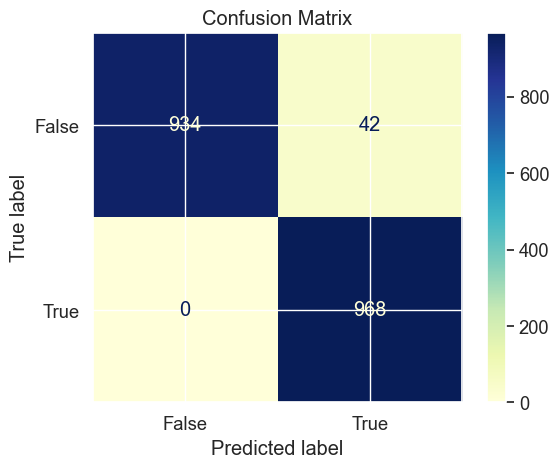

Accuracy: 0.9783950617283951
ROC AUC Score: 0.9980481980761414


In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score, roc_curve
from xgboost import XGBClassifier

# Assuming X_train, X_test, y_train, y_test are already defined

# Train the model
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb.predict(X_test)
y_pred_prob_xgb = xgb.predict_proba(X_test)[:, 1]

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y_test))
disp.plot(cmap='YlGnBu', values_format='d')
plt.title('Confusion Matrix')
plt.show()

# Print accuracy
print('Accuracy:', accuracy_score(y_test, y_pred_xgb))

# Print ROC AUC score
print('ROC AUC Score:', roc_auc_score(y_test, y_pred_prob_xgb))


We have 0 False Negatives. It means we were able to predict all patients who had a stroke

# Model Saving

In [62]:
import pickle as pkl
with open('xgb.pkl', 'wb')as file:
    pkl.dump(xgb, file)

In [63]:
with open('xgb.pkl','rb')as file:
    model=pkl.load(file)

In [64]:
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)